<img src="https://www.universidades.com.ec/logos/original/logo-universidad-politecnica-salesiana.png" style="margin: 0 auto"/>

<h1 style="text-align:center;color: red">Análisis del proceso de vacunación en Ecuador 🇪🇨</h1>

<ul style="text-align:center;list-style:none">
    <li><strong>Autor: </strong> Bryam David Vega Moreno</li>
    <li><strong>Maestro: </strong> Diego Quisi</li>
    <li><strong>Materia: </strong> Simulación</li>
    <li><strong>Universidad: </strong> Universidad Politécnica Salesiana</li>
    <li><strong>Carrera: </strong> Ciencias de la computación</li>
</ul>

-----------------

<h2 style="color:yellowgreen">Introducción</h2>

Con la llegada de las vacunas, el proceso de vacunación del país a empezado, en este cuaderno procedemos a realizar un análisis del proceso que se ha llevado a lo largo de la fecha con la finalidad de conocer si el proceso de vacunación del país es eficiente o presenta fallas en su ejecución. De la misma manera realizaremos un modelo de regresión que nos permite predecir el número de vacunados que habra en una cierta fech. Por otro lado realizaremos una comparación con Algunos países con respecto a su proceso de vacuncación con el objetivo de tener una referencia y comparar dichos planes.

------------------------

<h2 style="color:yellowgreen">Librerias a importar</h2>

**Para lectura y análisis de datos**

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime,timedelta

**Para la realización de gráficas**

In [2]:
import altair as alt
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'png'])
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.graph_objects as go

**Librerias para realizar el modelo de regresión**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

**Librerias para métricas de calidad**

In [4]:
from sklearn.metrics import mean_squared_error

**Mejorar visualización de datos**

In [5]:
pd.options.display.float_format='{:,.2f}'.format
import warnings
warnings.simplefilter("ignore")

-----------------------

<h2 style="color:yellowgreen">Lectura de parametros</h2>

In [6]:
fecha_inicio=''
fecha_fin=''

In [7]:
# Parameters
fecha_inicio = "2021-01-01"
fecha_fin = "2021-05-31"


-----------------------

<h2 style="color:yellowgreen">Lectura de datos</h2>

In [8]:
df_fabricantes = pd.read_csv('https://raw.githubusercontent.com/andrab/ecuacovid/master/datos_crudos/vacunas/fabricantes.csv')
df_vacunas     = pd.read_csv('https://raw.githubusercontent.com/andrab/ecuacovid/master/datos_crudos/vacunas/vacunas.csv')

<h4 style="color:orange">Datos de fabricantes de vacuna</h4>

En este conjunto de datos tenemos las siguientes características:
* **vaccine:** fabricante
* **total:** total de vacunas del fabricante llegadas al país en una fecha dada
* **arrived_at:** Fecha en la que llegaron al país, las vacunas del fabricante

In [9]:
df_fabricantes.head(5)

,vaccine,total,arrived_at
0,Pfizer/BioNTech,8190,20/01/2021
1,Pfizer/BioNTech,16380,17/02/2021
2,Pfizer/BioNTech,17550,24/02/2021
3,Pfizer/BioNTech,31590,03/03/2021
4,Sinovac,20000,06/03/2021


<h4 style="color:orange">Datos del proceso de vacunación</h4>

En este conjunto de datos tenemos las siguientes características:
* **fecha:** Fecha de vacuncación
* **dosis_total:** suma de las personas que tienen primera dosis y personas que tienen la segunda dosis
* **primera_dosis:** número de personas que solamente tienen la primera dosis
* **segunda_dosis:** número de personas que cuentan con la segunda dosis (por lo tanto número de personas totalmente inmunizadas hasta la fecha)

In [10]:
df_vacunas.head(5)

,fecha,dosis_total,primera_dosis,segunda_dosis
0,21/01/2021,0,0,0
1,22/01/2021,108,108,0
2,27/01/2021,2982,2982,0
3,04/02/2021,6228,6228,0
4,17/02/2021,8190,6228,1962


Con estos datos procedemos a realizar una transformación con la finalidad de tener noramlizadas y estandarizados, y poder realizar un mejor análisis.

--------------------

<h2 style="color:yellowgreen">Transformación de datos</h2>

In [11]:
def _transform_data_date(df,column_name):
    df[column_name]= pd.to_datetime(df[column_name],format='%d/%m/%Y')
    return df   

def _obtain_days_from_date(df,column_name,start_date):
    format_date = '%Y-%m-%d'
    df['day']=df[column_name].apply(lambda x : (x - datetime.strptime(start_date, format_date)).days +1)
    return df

def _save_data(df,filename):
    df.to_csv('./in/procesado/{}'.format(filename))

Para proceder a realizar la transforamción de los datos siempre es bueno realizar una copia del dataset original, con la finalidad de no modificar el conjunto de datos de origin y usar una copia para transformarlo y realizar un análisis con ello

In [12]:
df_copy_vacunas     = df_vacunas.copy(deep=True)
df_copy_fabricantes = df_fabricantes.copy(deep=True) 

Una vez realizado las copias de los conjunto de datos, procedemos a transformar la data y a guardarla en un nuevo conjunto de datos procesados.

<h4 style="color:orange">Transformación para los datos de vacunación</h4>

In [13]:
df_copy_vacunas = _transform_data_date(df_copy_vacunas,'fecha')
df_copy_vacunas = _obtain_days_from_date(df_copy_vacunas,'fecha','2021-01-01')
df_copy_vacunas = df_copy_vacunas[(df_copy_vacunas['fecha']>=fecha_inicio)&(df_copy_vacunas['fecha']<=fecha_fin)]
_save_data(df_copy_vacunas,'vacunas.csv')

In [14]:
df_copy_vacunas.head()

,fecha,dosis_total,primera_dosis,segunda_dosis,day
0,2021-01-21,0,0,0,21
1,2021-01-22,108,108,0,22
2,2021-01-27,2982,2982,0,27
3,2021-02-04,6228,6228,0,35
4,2021-02-17,8190,6228,1962,48


<h4 style="color:orange">Transformación para los datos de fabricantes</h4>

In [15]:
df_copy_fabricantes = _transform_data_date(df_copy_fabricantes,'arrived_at')
df_copy_fabricantes = _obtain_days_from_date(df_copy_fabricantes,'arrived_at','2021-01-01')
df_copy_fabricantes = df_copy_fabricantes[(df_copy_fabricantes['arrived_at']>=fecha_inicio)&(df_copy_fabricantes['arrived_at']<=fecha_fin)]
_save_data(df_copy_fabricantes,'fabricantes.csv')

In [16]:
df_copy_fabricantes

,vaccine,total,arrived_at,day
0,Pfizer/BioNTech,8190,2021-01-20,20
1,Pfizer/BioNTech,16380,2021-02-17,48
2,Pfizer/BioNTech,17550,2021-02-24,55
3,Pfizer/BioNTech,31590,2021-03-03,62
4,Sinovac,20000,2021-03-06,65
5,Pfizer/BioNTech,73710,2021-03-10,69
6,Oxford/AstraZeneca,84000,2021-03-17,76
7,Pfizer/BioNTech,62010,2021-03-17,76
8,Pfizer/BioNTech,65520,2021-03-24,83
9,Pfizer/BioNTech,66690,2021-03-31,90


Con estos datos transformados, procedemos a realizar un análisis con la finalidad de ver como se estan comportando nuestros datos y poder sacar algunas opiniones al respecto

------------------------------------

<h2 style="color:yellowgreen">Análisis Exploratorio</h2>

<h3 style="color:darkred"> Análisis a los datos de fabricantes</h3>

<h4 style="color:orange">Vacunas adquiridas por Ecuador</h4>

In [17]:
df_vaccines=df_copy_fabricantes.groupby(['vaccine',pd.Grouper(key='arrived_at',freq='M')])[['total']].sum()
df_vaccines

total
vaccine            arrived_at         
Oxford/AstraZeneca 2021-03-31    84000
                   2021-04-30   336000
Pfizer/BioNTech    2021-01-31     8190
                   2021-02-28    33930
                   2021-03-31   299520
                   2021-04-30   217620
                   2021-05-31   100620
Sinovac            2021-03-31    20000
                   2021-04-30  1000000

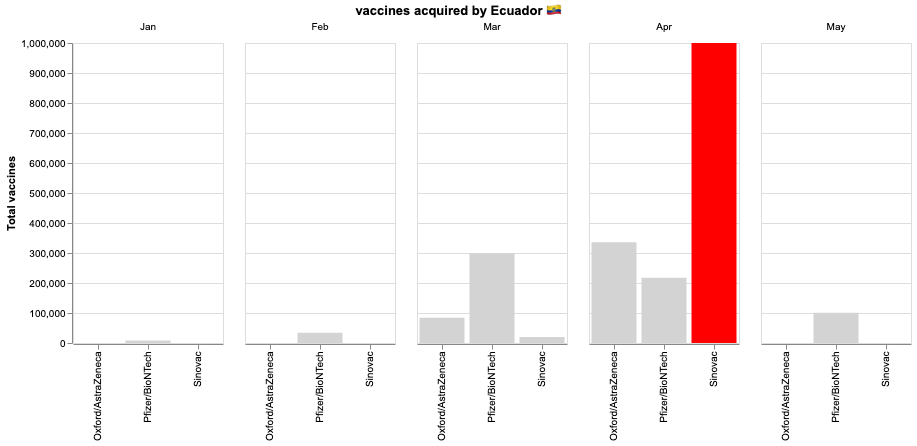

In [18]:
df_vaccines.reset_index(inplace=True)
figure=alt.Chart(df_vaccines).mark_bar().encode(
        x=alt.X('vaccine:O',title=''),
        y=alt.Y('total:Q',title='Total vaccines'),
        color=alt.condition(
            alt.datum.total == 1000000,
            alt.value('red'),    
            alt.value('lightgrey')
         ),
        column=alt.Column('month(arrived_at):N',title='')
    ).properties(title='vaccines acquired by Ecuador 🇪🇨',width=150
    ).configure_title(
        anchor='middle'
    )
figure

<h4 style="color:orange">Vacunas totales adquiridas por fabricante</h4>

In [19]:
df_fabricants=df_copy_fabricantes.groupby(['vaccine'])['total'].agg([np.sum])
df_fabricants

,sum
vaccine,
Oxford/AstraZeneca,420000
Pfizer/BioNTech,659880
Sinovac,1020000


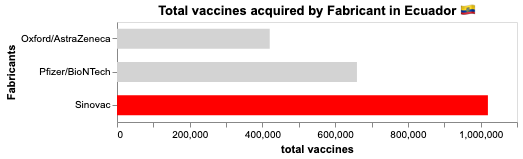

In [20]:
df_fabricants.reset_index(inplace=True)
figure_one = alt.Chart(df_fabricants).mark_bar(size=20).encode(
        x=alt.X('sum:Q',title='total vaccines'),
        y=alt.Y('vaccine:O',title='Fabricants'),
        color=alt.condition(
            alt.datum.vaccine == 'Sinovac',
            alt.value('red'),    
            alt.value('lightgrey')
            )
        ).properties(
            height=100,
            title='Total vaccines acquired by Fabricant in Ecuador 🇪🇨'
        ).configure_axis(
            grid=False
        )
figure_one

<h4 style="color:orange">Porcentaje de vacunas adquiridas en Ecuador por fabricante</h4>

In [21]:
df_percentage=df_copy_fabricantes.groupby(['vaccine'])[['total']].sum()
df_percentage['percentage']=(df_percentage['total']/df_percentage['total'].sum())*100
df_percentage

,total,percentage
vaccine,,
Oxford/AstraZeneca,420000,20.00
Pfizer/BioNTech,659880,31.42
Sinovac,1020000,48.57


In [22]:
df_percentage.reset_index(inplace=True)
fig = px.pie(df_percentage, values="percentage",
             names="vaccine", 
             color_discrete_sequence=['red','lightgrey','grey'],width=1000,height=500)
fig.update_layout(title_text='Porcentage vaccine by fabricant', title_x=0.5)

In [23]:
print('posible porcentaje de vacunación de la población ecuatoriana con primera dosis o con ambas dosis: {:.2f} %'.format(((df_percentage['total']/17370000)*100).sum()))
print('posible porcentaje de vacunación de la población ecuatoriana con ambas dosis: {:.2f} %'.format(((df_percentage['total']/17370000)*100).sum()/2))

posible porcentaje de vacunación de la población ecuatoriana con primera dosis o con ambas dosis: 12.09 %
posible porcentaje de vacunación de la población ecuatoriana con ambas dosis: 6.04 %


<h3 style="color:darkred"> Análisis a los datos de vacunas</h3>

<h4 style="color:orange">Gente vacunada en el Ecuador</h4>

In [24]:
df_vaccines_day= df_copy_vacunas[['fecha','primera_dosis','segunda_dosis']]
df_vaccines_day.head()

,fecha,primera_dosis,segunda_dosis
0,2021-01-21,0,0
1,2021-01-22,108,0
2,2021-01-27,2982,0
3,2021-02-04,6228,0
4,2021-02-17,6228,1962


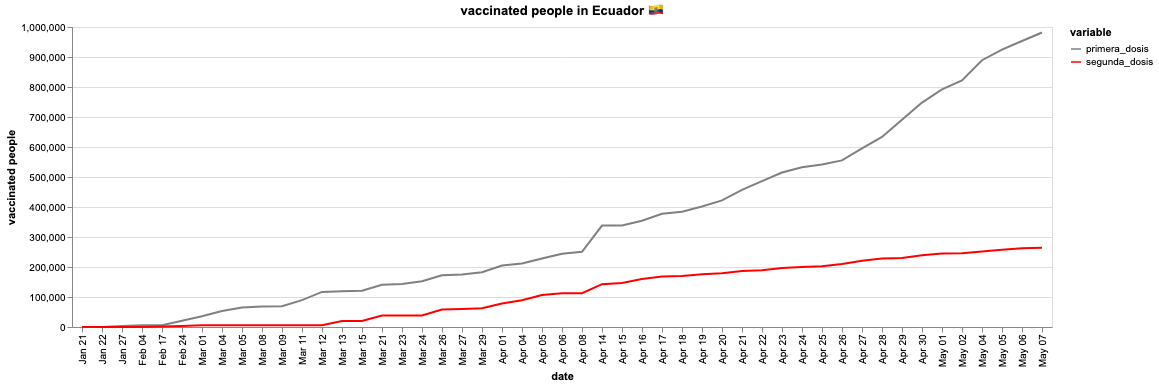

In [25]:
alt.Chart(df_vaccines_day.melt('fecha')).mark_line().encode(
    x=alt.X('monthdate(fecha):O',title='date'),
    y=alt.Y('value:Q',title='vaccinated people'),
    color=alt.Color('variable',scale=alt.Scale(domain=['primera_dosis','segunda_dosis'],range=['grey','red']))
).properties(title='vaccinated people in Ecuador 🇪🇨')

<h4 style="color:orange">Gente vacunada en el Ecuador por Mes</h4>

In [26]:
df_vaccine      = df_copy_vacunas.groupby(pd.Grouper(key='fecha',freq='M'))[['primera_dosis','segunda_dosis']].max()
df_vaccine_diff = df_vaccine.diff()
df_vaccine_diff = df_vaccine_diff.fillna(df_vaccine.head(1).to_dict())
df_vaccine_diff.head()

,primera_dosis,segunda_dosis
fecha,,
2021-01-31,"2,982.00",0.00
2021-02-28,"17,802.00","3,708.00"
2021-03-31,"161,545.00","58,829.00"
2021-04-30,"565,692.00","176,894.00"
2021-05-31,"233,599.00","24,771.00"


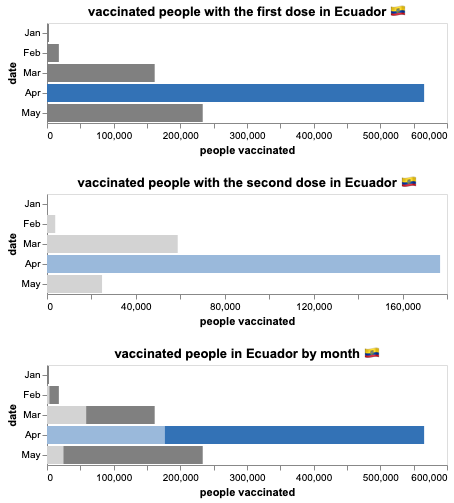

In [27]:
df_vaccine_diff.reset_index(inplace=True)
fig_1=alt.Chart(df_vaccine_diff).mark_bar().encode(
    x=alt.X('primera_dosis:Q',title='people vaccinated'),
    y=alt.Y('month(fecha):O',title='date'),
    color=alt.condition(
            alt.datum.primera_dosis == 565692.00,
            alt.value('rgb(51,114,182)'),    
            alt.value('grey')
            ),
).properties(
            height=100,
            title='vaccinated people with the first dose in Ecuador 🇪🇨'
)
fig_2=alt.Chart(df_vaccine_diff).mark_bar().encode(
    x=alt.X('segunda_dosis:Q',title='people vaccinated'),
    y=alt.Y('month(fecha):O',title='date'),
    color=alt.condition(
            alt.datum.segunda_dosis == 176894.00,
            alt.value('rgb(154,185,219)'),    
            alt.value('lightgrey')
            )
).properties(
            height=100,
            title='vaccinated people with the second dose in Ecuador 🇪🇨'
)
(fig_1&fig_2&(fig_1+fig_2).properties(title='vaccinated people in Ecuador by month 🇪🇨')).configure_axis(grid=False)

<h4 style="color:orange">Porcentaje de personas vacunadas en Ecuador</h4>

In [28]:
df_vaccine_percentage=df_copy_vacunas.iloc[df_copy_vacunas.shape[0]-1].to_dict()
dict_vaccine_percentage={ 'index': ['first dose','second dose','not vaccinated'],
                          'percentage':[df_vaccine_percentage['primera_dosis']/17370000*100,
                                       df_vaccine_percentage['segunda_dosis']/17370000*100,
                                       (17370000-df_vaccine_percentage['dosis_total'])/17370000*100]}
df_vaccine_percentage_ec=pd.DataFrame(dict_vaccine_percentage)
df_vaccine_percentage_ec

,index,percentage
0,first dose,5.65
1,second dose,1.52
2,not vaccinated,92.83


In [29]:
fig_one = px.pie(df_vaccine_percentage_ec, values="percentage",
             names="index", 
             color_discrete_sequence=['red','lightgrey','grey'],width=1000,height=500)
fig_one.update_layout(title_text='vaccinated people in Ecuador 🇪🇨', title_x=0.5)

<h3 style="color:darkred"> Comparación del proceso de vacunación de Chile contra Ecuador</h3>

In [30]:
df_vacunas_chile = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto76/vacunacion_t.csv')
df_vacunas_chile = df_vacunas_chile[['Region','Total','Total.1']]
df_vacunas_chile = df_vacunas_chile.drop(0,axis=0)
df_vacunas_chile.columns = ['fecha','primera_dosis','segunda_dosis']
df_vacunas_chile[['primera_dosis','segunda_dosis']] = df_vacunas_chile[['primera_dosis','segunda_dosis']].astype(np.float)
df_vacunas_chile['fecha']= pd.to_datetime(df_vacunas_chile['fecha'])
df_vacunas_chile['dosis_total'] = df_vacunas_chile['primera_dosis']+df_vacunas_chile['segunda_dosis']
df_vacunas_chile = df_vacunas_chile[(df_vacunas_chile['fecha']>=fecha_inicio)&(df_vacunas_chile['fecha']<=fecha_fin)]

In [31]:
df_vacunas_chile.head()

,fecha,primera_dosis,segunda_dosis,dosis_total
9,2021-01-01,"8,649.00",0.00,"8,649.00"
10,2021-01-02,"8,649.00",0.00,"8,649.00"
11,2021-01-03,"8,649.00",0.00,"8,649.00"
12,2021-01-04,"9,054.00",0.00,"9,054.00"
13,2021-01-05,"10,497.00",0.00,"10,497.00"


<h4 style="color:orange">Gente vacunada en Chile</h4>

In [32]:
df_vaccine_chile = df_vacunas_chile[['fecha','primera_dosis','segunda_dosis']]
df_vaccine_chile = df_vaccine_chile.groupby(pd.Grouper(key='fecha',freq='W'))[['primera_dosis','segunda_dosis']].max()
df_vaccine_chile.head()

,primera_dosis,segunda_dosis
fecha,,
2021-01-03,"8,649.00",0.00
2021-01-10,"10,702.00",0.00
2021-01-17,"13,801.00","8,366.00"
2021-01-24,"56,964.00","8,368.00"
2021-01-31,"57,004.00","10,405.00"


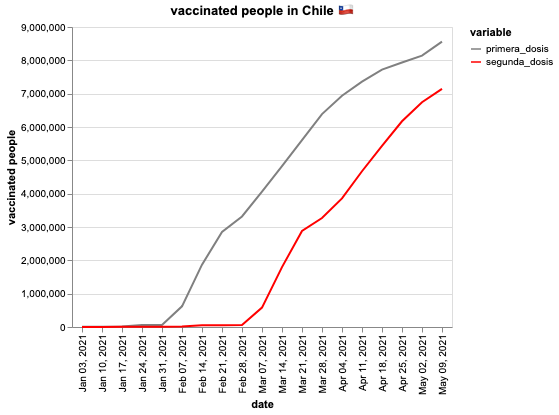

In [33]:
df_vaccine_chile.reset_index(inplace=True)
alt.Chart(df_vaccine_chile.melt('fecha')).mark_line().encode(
    x=alt.X('yearmonthdate(fecha):O',title='date'),
    y=alt.Y('value:Q',title='vaccinated people'),
    color=alt.Color('variable',scale=alt.Scale(domain=['primera_dosis','segunda_dosis'],range=['grey','red']))
).properties(title='vaccinated people in Chile 🇨🇱')

<h4 style="color:orange">Gente vacunada en Chile por Mes</h4>

In [34]:
df_vaccine      = df_vacunas_chile.groupby(pd.Grouper(key='fecha',freq='M'))[['primera_dosis','segunda_dosis']].max()
df_vaccine_diff = df_vaccine.diff()
df_vaccine_diff = df_vaccine_diff.fillna(df_vaccine.head(1).to_dict())
df_vaccine_diff.head()

,primera_dosis,segunda_dosis
fecha,,
2021-01-31,"57,004.00","10,405.00"
2021-02-28,"3,259,272.00","45,885.00"
2021-03-31,"3,481,473.00","3,624,932.00"
2021-04-30,"1,342,607.00","3,059,210.00"
2021-05-31,"420,835.00","404,152.00"


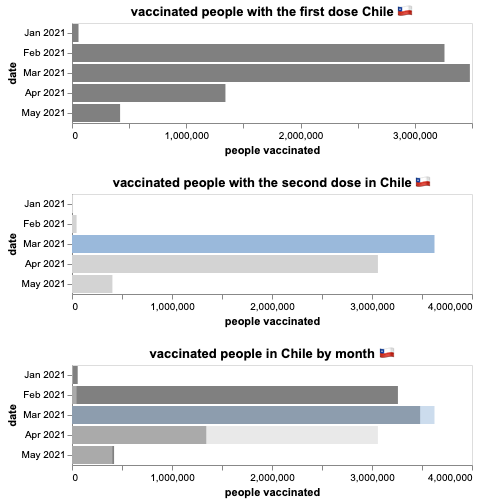

In [35]:
df_vaccine_diff.reset_index(inplace=True)
fig_1=alt.Chart(df_vaccine_diff).mark_bar().encode(
    x=alt.X('primera_dosis:Q',title='people vaccinated'),
    y=alt.Y('yearmonth(fecha):O',title='date'),
    color=alt.condition(
            alt.datum.primera_dosis == 3481471.00,
            alt.value('rgb(51,114,182)'),    
            alt.value('grey')
            ),
).properties(
            height=100,
            title='vaccinated people with the first dose Chile 🇨🇱'
)
fig_2=alt.Chart(df_vaccine_diff).mark_bar().encode(
    x=alt.X('segunda_dosis:Q',title='people vaccinated'),
    y=alt.Y('yearmonth(fecha):O',title='date'),
    color=alt.condition(
            alt.datum.segunda_dosis == 3624932.00,
            alt.value('rgb(154,185,219)'),    
            alt.value('lightgrey')
            )
).properties(
            height=100,
            title='vaccinated people with the second dose in Chile 🇨🇱'
)
(fig_1&fig_2&(fig_1+fig_2.encode(opacity=alt.value(0.5))).properties(title='vaccinated people in Chile by month 🇨🇱')).configure_axis(grid=False)

<h4 style="color:orange">Porcentaje de personas vacunadas en Chile</h4>

In [36]:
df_vaccine_percentage=df_vacunas_chile.iloc[df_vacunas_chile.shape[0]-1].to_dict()
dict_vaccine_percentage={ 'index': ['first dose','second dose','not vaccinated'],
                          'percentage':[df_vaccine_percentage['primera_dosis']/18950000*100,
                                       df_vaccine_percentage['segunda_dosis']/18950000*100,
                                       (18950000-df_vaccine_percentage['dosis_total'])/18950000*100]}
df_vaccine_percentage_ch=pd.DataFrame(dict_vaccine_percentage)
df_vaccine_percentage_ch

,index,percentage
0,first dose,45.18
1,second dose,37.70
2,not vaccinated,17.12


In [37]:
fig_two = px.pie(df_vaccine_percentage_ch, values="percentage",
             names="index", 
             color_discrete_sequence=['red','lightgrey','grey'],width=1000,height=500)
fig_two.update_layout(title_text='vaccinated people in Chile 🇨🇱', title_x=0.5)

<h3 style="color:darkred"> Comparación del proceso de vacunación de Inglaterra contra Ecuador</h3>

In [38]:
df_vacunas_inglaterra = pd.read_csv('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=overview&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newVaccinesGivenByPublishDate%22:%22newVaccinesGivenByPublishDate%22,%22cumVaccinesGivenByPublishDate%22:%22cumVaccinesGivenByPublishDate%22,%22newPeopleVaccinatedFirstDoseByPublishDate%22:%22newPeopleVaccinatedFirstDoseByPublishDate%22,%22cumPeopleVaccinatedFirstDoseByPublishDate%22:%22cumPeopleVaccinatedFirstDoseByPublishDate%22,%22newPeopleVaccinatedSecondDoseByPublishDate%22:%22newPeopleVaccinatedSecondDoseByPublishDate%22,%22cumPeopleVaccinatedSecondDoseByPublishDate%22:%22cumPeopleVaccinatedSecondDoseByPublishDate%22%7D&format=csv')
df_vacunas_inglaterra = df_vacunas_inglaterra[['date','cumPeopleVaccinatedFirstDoseByPublishDate','cumPeopleVaccinatedSecondDoseByPublishDate']]
df_vacunas_inglaterra.columns = ['fecha','primera_dosis','segunda_dosis']
df_vacunas_inglaterra['fecha'] = pd.to_datetime(df_vacunas_inglaterra['fecha'])
df_vacunas_inglaterra['dosis_total'] = df_vacunas_inglaterra['primera_dosis']+df_vacunas_inglaterra['segunda_dosis']
df_vacunas_inglaterra = df_vacunas_inglaterra[(df_vacunas_inglaterra['fecha']>=fecha_inicio)&(df_vacunas_inglaterra['fecha']<=fecha_fin)]
df_vacunas_inglaterra.head()

,fecha,primera_dosis,segunda_dosis,dosis_total
0,2021-05-08,35371669,17669379,53041048
1,2021-05-07,35202642,17230542,52433184
2,2021-05-06,35069641,16764720,51834361
3,2021-05-05,34934171,16291719,51225890
4,2021-05-04,34795074,15887493,50682567


<h4 style="color:orange">Gente vacunada en Inglaterra</h4>

In [39]:
df_vaccine_england = df_vacunas_inglaterra[['fecha','primera_dosis','segunda_dosis']]
df_vaccine_england = df_vaccine_england.groupby(pd.Grouper(key='fecha',freq='W'))[['primera_dosis','segunda_dosis']].max()
df_vaccine_england.head()

,primera_dosis,segunda_dosis
fecha,,
2021-01-10,2286572,391399
2021-01-17,4062501,452301
2021-01-24,6573570,470478
2021-01-31,9296367,494209
2021-02-07,12294006,512581


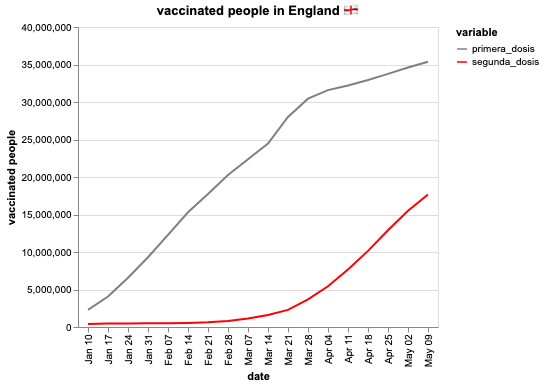

In [40]:
df_vaccine_england.reset_index(inplace=True)
alt.Chart(df_vaccine_england.melt('fecha')).mark_line().encode(
    x=alt.X('monthdate(fecha):O',title='date'),
    y=alt.Y('value:Q',title='vaccinated people'),
    color=alt.Color('variable',scale=alt.Scale(domain=['primera_dosis','segunda_dosis'],range=['grey','red']))
).properties(title='vaccinated people in England 🏴󠁧󠁢󠁥󠁮󠁧󠁿')

<h4 style="color:orange">Gente vacunada en Inglaterra por Mes</h4>

In [41]:
df_vaccine      = df_vacunas_inglaterra.groupby(pd.Grouper(key='fecha',freq='M'))[['primera_dosis','segunda_dosis']].max()
df_vaccine_diff = df_vaccine.diff()
df_vaccine_diff = df_vaccine_diff.fillna(df_vaccine.head(1).to_dict())
df_vaccine_diff.head()

,primera_dosis,segunda_dosis
fecha,,
2021-01-31,"9,296,367.00","494,209.00"
2021-02-28,"10,979,084.00","321,607.00"
2021-03-31,"10,871,993.00","3,697,642.00"
2021-04-30,"3,214,761.00","10,443,855.00"
2021-05-31,"1,009,464.00","2,712,066.00"


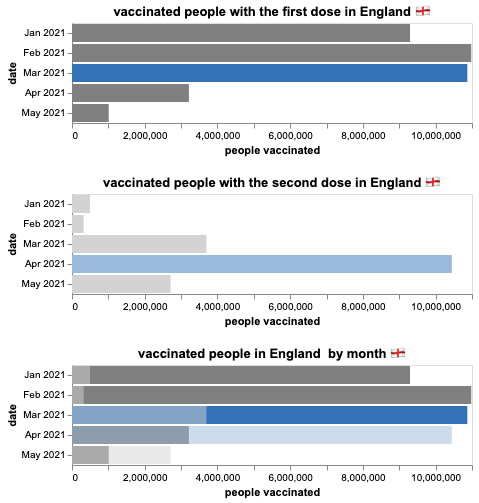

In [42]:
df_vaccine_diff.reset_index(inplace=True)
fig_1=alt.Chart(df_vaccine_diff).mark_bar().encode(
    x=alt.X('primera_dosis:Q',title='people vaccinated'),
    y=alt.Y('yearmonth(fecha):O',title='date'),
    color=alt.condition(
            alt.datum.primera_dosis == 10871993.00,
            alt.value('rgb(51,114,182)'),    
            alt.value('grey')
            ),
).properties(
            height=100,
            title='vaccinated people with the first dose in England 🏴󠁧󠁢󠁥󠁮󠁧󠁿'
)
fig_2=alt.Chart(df_vaccine_diff).mark_bar().encode(
    x=alt.X('segunda_dosis:Q',title='people vaccinated'),
    y=alt.Y('yearmonth(fecha):O',title='date'),
    color=alt.condition(
            alt.datum.segunda_dosis == 10443855.00,
            alt.value('rgb(154,185,219)'),    
            alt.value('lightgrey')
            )
).properties(
            height=100,
            title='vaccinated people with the second dose in England 🏴󠁧󠁢󠁥󠁮󠁧󠁿'
)
(fig_1&fig_2&(fig_1+fig_2.encode(opacity=alt.value(0.5))).properties(title='vaccinated people in England 󠁧󠁢󠁥󠁮󠁧󠁿 by month 🏴󠁧󠁢󠁥󠁮󠁧󠁿')).configure_axis(grid=False)

<h4 style="color:orange">Porcentaje de personas vacunadas en Inglaterra</h4>

In [43]:
df_vaccine_percentage=df_vacunas_inglaterra.sort_values('fecha').iloc[df_vacunas_inglaterra.shape[0]-1].to_dict()
dict_vaccine_percentage={ 'index': ['first dose','second dose','not vaccinated'],
                          'percentage':[df_vaccine_percentage['primera_dosis']/55980000*100,
                                       df_vaccine_percentage['segunda_dosis']/55980000*100,
                                       (55980000-df_vaccine_percentage['dosis_total'])/55980000*100]}
df_vaccine_percentage_en=pd.DataFrame(dict_vaccine_percentage)
df_vaccine_percentage_en

,index,percentage
0,first dose,63.19
1,second dose,31.56
2,not vaccinated,5.25


In [44]:
fig_three = px.pie(df_vaccine_percentage_en, values="percentage",
             names="index", 
             color_discrete_sequence=['red','lightgrey','grey'],width=1000,height=500)
fig_three.update_layout(title_text='vaccinated people in England 🏴󠁧󠁢󠁥󠁮󠁧󠁿', title_x=0.5)

<h3 style="color:darkred"> Comparación del proceso de vacunación entre Inglaterra, Chile y Ecuador</h3>

In [45]:
fig = make_subplots(rows=1, cols=3,specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"}]])
fig.add_trace(go.Pie(labels=df_vaccine_percentage_ch['index'].values, values=df_vaccine_percentage_ch['percentage'].values,
                     marker_colors=['red','lightgrey','grey'],title_text='Chile 🇨🇱'),row=1, col=1)
fig.add_trace(go.Pie(labels=df_vaccine_percentage_en['index'].values, values=df_vaccine_percentage_en['percentage'].values,
                     marker_colors=['red','lightgrey','grey'],title_text='England 🏴󠁧󠁢󠁥󠁮󠁧󠁿'),row=1, col=2)
fig.add_trace(go.Pie(labels=df_vaccine_percentage_ec['index'].values, values=df_vaccine_percentage_ec['percentage'].values,
                     marker_colors=['red','lightgrey','grey'],title_text='Ecuador 🇪🇨'),row=1, col=3)
fig.update_layout(width=1000,title='Comparison of vaccinated people between Ecuador, England and Chile',title_x=0.5)

-----------------------------

<h2 style="color:yellowgreen">Un modelo de regresión para el proceso de vacunación</h2>

In [46]:
del df_copy_vacunas
del df_vacunas_chile
del df_vacunas_inglaterra
df_copy_vacunas = df_vacunas.copy(deep=True)
df_copy_vacunas = _transform_data_date(df_copy_vacunas,'fecha')
df_copy_vacunas = _obtain_days_from_date(df_copy_vacunas,'fecha','2021-01-01')

df_vacunas_chile = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto76/vacunacion_t.csv')
df_vacunas_chile = df_vacunas_chile[['Region','Total','Total.1']]
df_vacunas_chile = df_vacunas_chile.drop(0,axis=0)
df_vacunas_chile.columns = ['fecha','primera_dosis','segunda_dosis']
df_vacunas_chile[['primera_dosis','segunda_dosis']] = df_vacunas_chile[['primera_dosis','segunda_dosis']].astype(np.float)
df_vacunas_chile['fecha']= pd.to_datetime(df_vacunas_chile['fecha'])
df_vacunas_chile['dosis_total'] = df_vacunas_chile['primera_dosis']+df_vacunas_chile['segunda_dosis']

df_vacunas_inglaterra = pd.read_csv('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=overview&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newVaccinesGivenByPublishDate%22:%22newVaccinesGivenByPublishDate%22,%22cumVaccinesGivenByPublishDate%22:%22cumVaccinesGivenByPublishDate%22,%22newPeopleVaccinatedFirstDoseByPublishDate%22:%22newPeopleVaccinatedFirstDoseByPublishDate%22,%22cumPeopleVaccinatedFirstDoseByPublishDate%22:%22cumPeopleVaccinatedFirstDoseByPublishDate%22,%22newPeopleVaccinatedSecondDoseByPublishDate%22:%22newPeopleVaccinatedSecondDoseByPublishDate%22,%22cumPeopleVaccinatedSecondDoseByPublishDate%22:%22cumPeopleVaccinatedSecondDoseByPublishDate%22%7D&format=csv')
df_vacunas_inglaterra = df_vacunas_inglaterra[['date','cumPeopleVaccinatedFirstDoseByPublishDate','cumPeopleVaccinatedSecondDoseByPublishDate']]
df_vacunas_inglaterra.columns = ['fecha','primera_dosis','segunda_dosis']
df_vacunas_inglaterra['fecha'] = pd.to_datetime(df_vacunas_inglaterra['fecha'])
df_vacunas_inglaterra['dosis_total'] = df_vacunas_inglaterra['primera_dosis']+df_vacunas_inglaterra['segunda_dosis']

In [47]:
df_vacunas_inglaterra['country']='Inglaterra'
df_vacunas_chile['country']='Chile'
df_copy_vacunas['country']='Ecuador'
df_final = df_copy_vacunas.append(df_vacunas_chile).append(df_vacunas_inglaterra)
df_final = _obtain_days_from_date(df_final,'fecha','2021-01-01')
df_final = df_final[df_final['fecha']>='2021-01-01']
_save_data(df_final,'datos_vacunas.csv')

In [48]:
df_final.head()

,fecha,dosis_total,primera_dosis,segunda_dosis,day,country
0,2021-01-21,0.00,0.00,0.00,21,Ecuador
1,2021-01-22,108.00,108.00,0.00,22,Ecuador
2,2021-01-27,"2,982.00","2,982.00",0.00,27,Ecuador
3,2021-02-04,"6,228.00","6,228.00",0.00,35,Ecuador
4,2021-02-17,"8,190.00","6,228.00","1,962.00",48,Ecuador


<h3 style="color:darkred"> Modelo de regresión para Ecuador</h3>

<h4 style="color:orange">Primera dosis</h4>

In [49]:
df=df_final[df_final['country']=='Ecuador'][['day','primera_dosis']]
features=df.iloc[:,:1].values
target=df.iloc[:,1:2].values

In [50]:
model_linear_ec_fs = LinearRegression()
model_linear_ec_fs = model_linear_ec_fs.fit(features,target)

In [51]:
score_ec_linear_fs = model_linear_ec_fs.score(features,target)
print("Linear Score : ",model_linear_ec_fs.score(features,target))

Linear Score :  0.7547024425600521


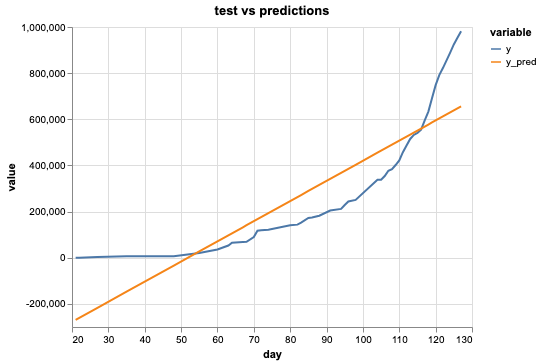

In [52]:
data_linear_ec_fs=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_linear_ec_fs.predict(features).reshape(-1)})
alt.Chart(data_linear_ec_fs.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

In [53]:
model_poly_ec_fs = np.poly1d(np.polyfit(features.reshape(-1), target.reshape(-1), 4))

In [54]:
score_ec_poly_fs = mean_squared_error(target,model_poly_ec_fs(features.reshape(-1)))/1000000000000
print("Poly Score : ",mean_squared_error(target,model_poly_ec_fs(features.reshape(-1)))/1000000000000)

Poly Score :  0.0002590547285571527


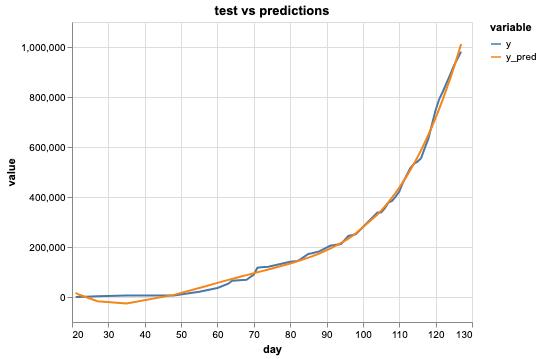

In [55]:
data_poly_ec_fs=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_poly_ec_fs(features.reshape(-1))})
alt.Chart(data_poly_ec_fs.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

<h4 style="color:orange">Segunda dosis</h4>

In [56]:
df=df_final[df_final['country']=='Ecuador'][['day','segunda_dosis']]
features=df.iloc[:,:1].values
target=df.iloc[:,1:2].values

In [57]:
model_linear_ec_ds = LinearRegression()
model_linear_ec_ds = model_linear_ec_ds.fit(features,target)

In [58]:
score_ec_linear_ds = model_linear_ec_ds.score(features,target)
print("Linear Score : ",model_linear_ec_ds.score(features,target))

Linear Score :  0.8390341082230389


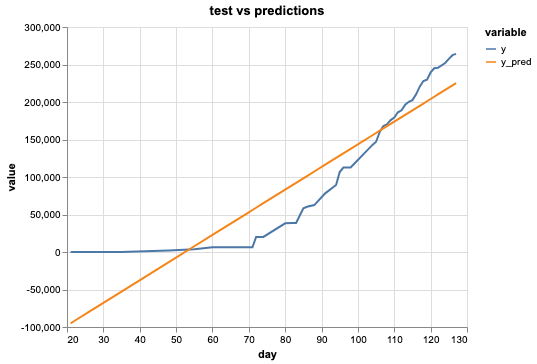

In [59]:
data_linear_ec_ds=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_linear_ec_ds.predict(features).reshape(-1)})
alt.Chart(data_linear_ec_ds.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

In [60]:
model_poly_ec_ds = Pipeline([('poly', PolynomialFeatures(degree=6)),
                         ('linear', LinearRegression(fit_intercept=True))])
model_poly_ec_ds = model_poly_ec_ds.fit(features,target)

In [61]:
score_ec_poly_ds=model_poly_ec_ds.score(features,target)
print("Poly Score : ",model_poly_ec_ds.score(features,target))

Poly Score :  0.9984821251992739


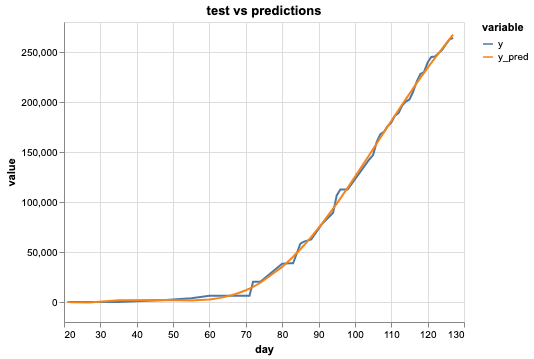

In [62]:
data_poly_ec_ds=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_poly_ec_ds.predict(features).reshape(-1)})
alt.Chart(data_poly_ec_ds.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

<h3 style="color:darkred"> Modelo de regresión para Chile</h3>

<h4 style="color:orange">Primera dosis</h4>

In [63]:
df=df_final[df_final['country']=='Chile'][['day','primera_dosis']]
features=df.iloc[:,:1].values
target=df.iloc[:,1:2].values

In [64]:
model_linear_ch_fs = LinearRegression()
model_linear_ch_fs = model_linear_ch_fs.fit(features,target)

In [65]:
score_ch_linear_fs = model_linear_ch_fs.score(features,target)
print("Linear Score : ",model_linear_ch_fs.score(features,target))

Linear Score :  0.9670194286738074


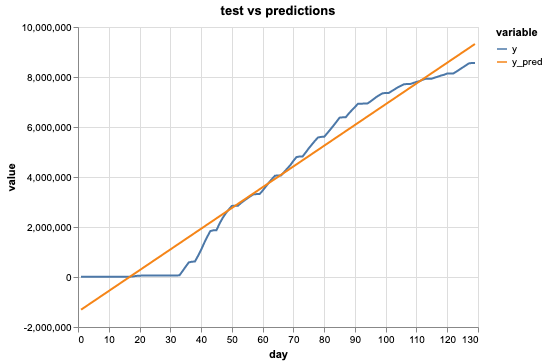

In [66]:
data_linear_ch_fs=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_linear_ch_fs.predict(features).reshape(-1)})
alt.Chart(data_linear_ch_fs.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

In [67]:
model_poly_ch_fs = Pipeline([('poly', PolynomialFeatures(degree=5)),
                         ('linear', LinearRegression(fit_intercept=True))])
model_poly_ch_fs = model_poly_ch_fs.fit(features,target)

In [68]:
score_ch_poly_fs = model_poly_ch_fs.score(features,target)
print("Poly Score : ",model_poly_ch_fs.score(features,target))

Poly Score :  0.9965833119223415


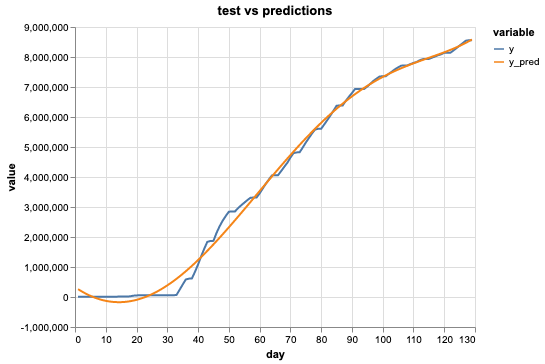

In [69]:
data_poly_ch_fs=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_poly_ch_fs.predict(features).reshape(-1)})
alt.Chart(data_poly_ch_fs.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

<h4 style="color:orange">Segunda dosis</h4>

In [70]:
df=df_final[df_final['country']=='Chile'][['day','segunda_dosis']]
features=df.iloc[:,:1].values
target=df.iloc[:,1:2].values

In [71]:
model_linear_ch_ds = LinearRegression()
model_linear_ch_ds = model_linear_ch_ds.fit(features,target)

In [72]:
score_ch_linear_ds = model_linear_ch_ds.score(features,target)
print("Linear Score : ",model_linear_ch_ds.score(features,target))

Linear Score :  0.8594363147326256


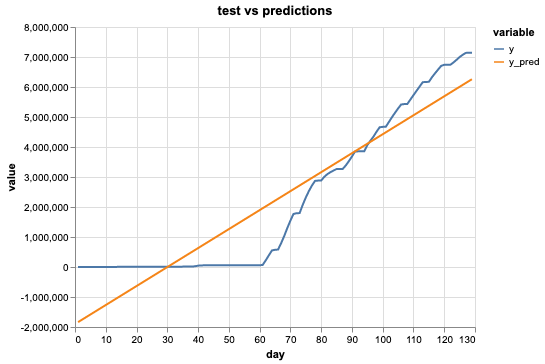

In [73]:
data_linear_ch_ds=pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_linear_ch_ds.predict(features).reshape(-1)})
alt.Chart(data_linear_ch_ds.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

In [74]:
model_poly_ch_ds = Pipeline([('poly', PolynomialFeatures(degree=6)),
                         ('linear', LinearRegression(fit_intercept=True))])
model_poly_ch_ds = model_poly_ch_ds.fit(features,target)

In [75]:
score_ch_poly_ds = model_poly_ch_ds.score(features,target)
print("Poly Score : ",model_poly_ch_ds.score(features,target))

Poly Score :  0.9936541878097539


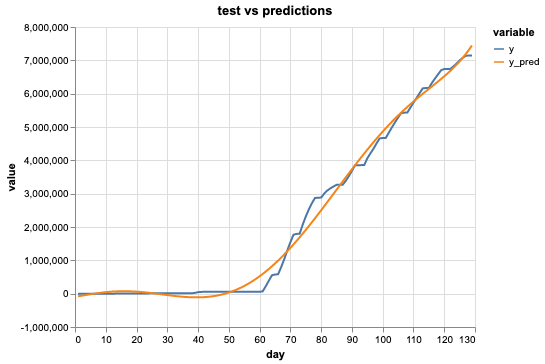

In [76]:
data_poly_ch_ds = pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_poly_ch_ds.predict(features).reshape(-1)})
alt.Chart(data_poly_ch_ds.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

<h3 style="color:darkred"> Modelo de regresión para Inglaterra</h3>

<h4 style="color:orange">Primera dosis</h4>

In [77]:
df=df_final[df_final['country']=='Inglaterra'][['day','primera_dosis']]
features=df.iloc[:,:1].values
target=df.iloc[:,1:2].values

In [78]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [79]:
model_linear_en_fs = LinearRegression()
model_linear_en_fs = model_linear_en_fs.fit(features,target)

In [80]:
score_en_linear_fs = model_linear_en_fs.score(features,target)
print("Linear Score : ",model_linear_en_fs.score(features,target))

Linear Score :  0.9667243111015937


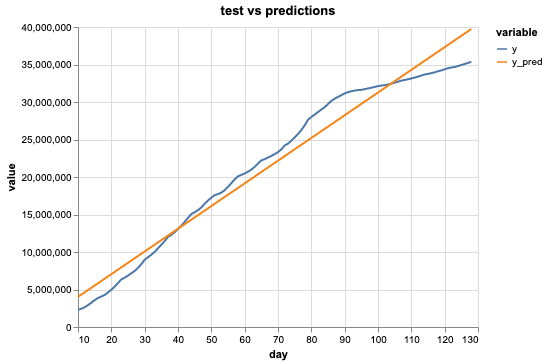

In [81]:
data_linear_en_fs = pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_linear_en_fs.predict(features).reshape(-1)})
alt.Chart(data_linear_en_fs.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

In [82]:
model_poly_en_fs = Pipeline([('poly', PolynomialFeatures(degree=6)),
                        ('linear', LinearRegression(fit_intercept=True))])
model_poly_en_fs = model_poly_en_fs.fit(features,target)

In [83]:
score_en_poly_fs = model_poly_en_fs.score(features,target)
print("Poly Score : ",model_poly_en_fs.score(features,target))

Poly Score :  0.9989307862471187


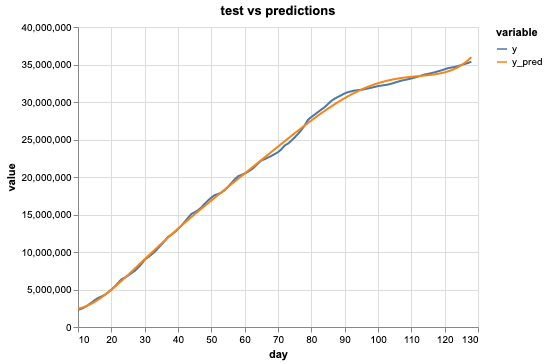

In [84]:
data_poly_en_fs = pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_poly_en_fs.predict(features).reshape(-1)})
alt.Chart(data_poly_en_fs.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

<h4 style="color:orange">Segunda dosis</h4>

In [85]:
df=df_final[df_final['country']=='Inglaterra'][['day','segunda_dosis']]
features=df.iloc[:,:1].values
target=df.iloc[:,1:2].values

In [86]:
model_linear_en_ds = LinearRegression()
model_linear_en_ds = model_linear_en_ds.fit(features,target)

In [87]:
score_en_linear_ds = model_linear_en_ds.score(features,target)
print("Linear Score : ",model_linear_en_ds.score(features,target))

Linear Score :  0.7522278275852885


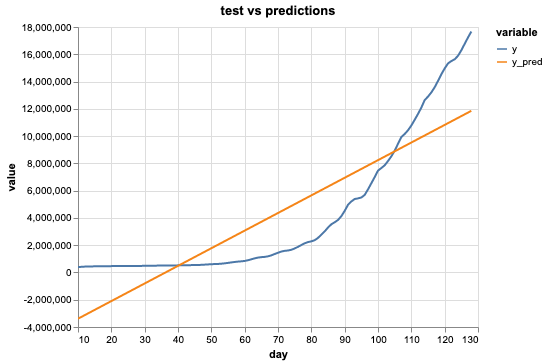

In [88]:
data_linear_en_ds = pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_linear_en_ds.predict(features).reshape(-1)})
alt.Chart(data_linear_en_ds.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

In [89]:
model_poly_en_ds = Pipeline([('poly', PolynomialFeatures(degree=9)),
                        ('linear', LinearRegression(fit_intercept=True))])
model_poly_en_ds = model_poly_en_ds.fit(features,target)

In [90]:
score_en_poly_ds = model_poly_en_ds.score(features,target)
print("Poly Score : ",model_poly_en_ds.score(features,target))

Poly Score :  0.9995948902007117


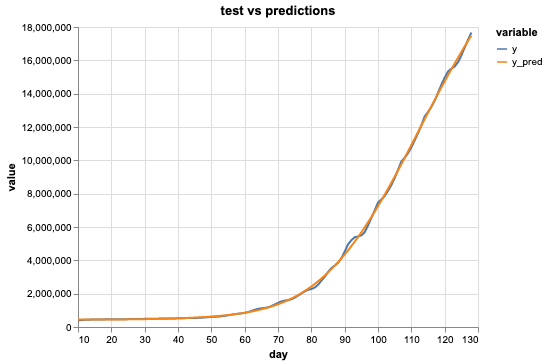

In [91]:
data_poly_en_ds = pd.DataFrame({'day':features.reshape(-1),'y':target.reshape(-1),'y_pred':model_poly_en_ds.predict(features).reshape(-1)})
alt.Chart(data_poly_en_ds.melt('day')).mark_line().encode(
    x='day',
    y='value',
    color='variable'
).properties(title='test vs predictions').interactive()

------------------------------------------------

<h2 style="color:yellowgreen">Análisis de los modelos de regresión</h2>

Una vez ejecutados todos los modelos, procedemos a realiar un análisis de cada uno de ellos obtiendo los siguientes resultados

In [92]:
dict_results = {'country':['Ecuador','Chile','Inglaterra'],
               'linear_fd':[score_ec_linear_fs,score_ch_linear_fs,score_en_linear_fs],
               'poly_fd':[score_ec_poly_fs,score_ch_poly_fs,score_en_poly_fs],
               'linear_sd':[score_ec_linear_ds,score_ch_linear_ds,score_en_linear_ds],
               'poly_sd':[score_ec_poly_ds,score_ch_poly_ds,score_en_poly_ds]}
df_results = pd.DataFrame(dict_results)

In [93]:
df_results

,country,linear_fd,poly_fd,linear_sd,poly_sd
0,Ecuador,0.75,0.00,0.84,1.00
1,Chile,0.97,1.00,0.86,0.99
2,Inglaterra,0.97,1.00,0.75,1.00


-----------------------------------

<h2 style="color:yellowgreen">Experimentos</h2>

In [94]:
df_final[df_final['fecha']=='2021-05-08']

,fecha,dosis_total,primera_dosis,segunda_dosis,day,country
136,2021-05-08,"15,704,425.00","8,560,258.00","7,144,167.00",128,Chile
0,2021-05-08,"53,041,048.00","35,371,669.00","17,669,379.00",128,Inglaterra


In [95]:
inicio = datetime(2021,5,9)
fin    = datetime(2021,8,9)
lista_fechas = [(inicio + timedelta(days=d)).strftime("%Y-%m-%d")
                    for d in range((fin - inicio).days + 1)]
datos = [i for i in range(129,128+len(lista_fechas)+1)]

<h3 style="color:darkred"> Ecuador 🇪🇨</h3>

<h4 style="color:orange">Primera dosis</h4>

In [96]:
dictionary_ec={'fecha':lista_fechas,
            'linear_fd_ec':model_linear_ec_fs.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1),
            'poly_fd_ec':model_poly_ec_fs(np.array(datos).reshape(-1)),}
df_ec=pd.DataFrame(dictionary_ec)
df_ec['fecha']=pd.to_datetime(df_ec['fecha'])
df_ec=df_ec.groupby(pd.Grouper(key='fecha',freq='5D')).max()

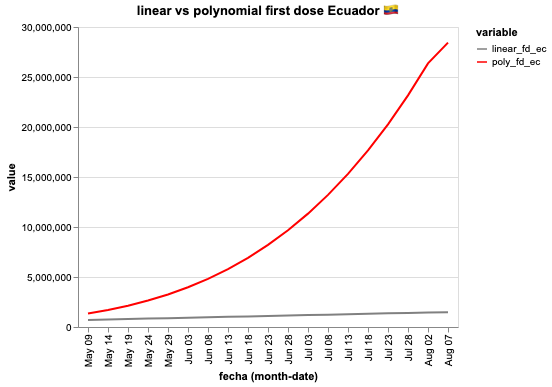

In [97]:
df_ec=df_ec.reset_index()
alt.Chart(df_ec.reset_index().melt('fecha')).mark_line().encode(
    x='monthdate(fecha):N',
    y=alt.Y('value:Q'),
    color=alt.Color('variable',scale=alt.Scale(domain=['linear_fd_ec','poly_fd_ec'],range=['grey','red']))
).properties(title='linear vs polynomial first dose Ecuador 🇪🇨')


<h4 style="color:orange">Segunda dosis</h4>

In [98]:
dictionary_ec={'fecha':lista_fechas,
            'linear_sd_ec':model_linear_ec_ds.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1),
            'poly_sd_ec':model_poly_ec_ds.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1),}
df_ec=pd.DataFrame(dictionary_ec)
df_ec['fecha']=pd.to_datetime(df_ec['fecha'])
df_ec=df_ec.groupby(pd.Grouper(key='fecha',freq='5D')).max()

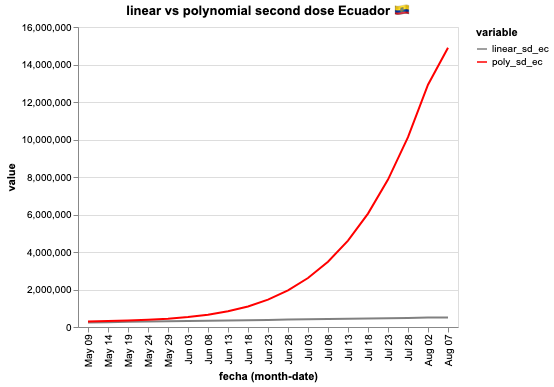

In [99]:
df_ec=df_ec.reset_index()
alt.Chart(df_ec.melt('fecha')).mark_line().encode(
    x='monthdate(fecha):N',
    y=alt.Y('value:Q'),
    color=alt.Color('variable',scale=alt.Scale(domain=['linear_sd_ec','poly_sd_ec'],range=['grey','red']))
).properties(title='linear vs polynomial second dose Ecuador 🇪🇨')


<h3 style="color:darkred"> Chile 🇨🇱 e Inglaterra 🏴󠁧󠁢󠁥󠁮󠁧󠁿</h3>

In [100]:
inicio = datetime(2021,5,9)
fin    = datetime(2021,7,10)
lista_fechas = [(inicio + timedelta(days=d)).strftime("%Y-%m-%d")
                    for d in range((fin - inicio).days + 1)]
datos = [i for i in range(129,128+len(lista_fechas)+1)]

<h4 style="color:orange">Primera dosis</h4>

In [101]:
dictionary_ce={'fecha':lista_fechas,
            'chile':model_poly_ch_fs.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1),
            'inglaterra':model_poly_en_fs.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1)}
df_ce=pd.DataFrame(dictionary_ce)
df_ce['fecha']=pd.to_datetime(df_ce['fecha'])
df_ce=df_ce.groupby(pd.Grouper(key='fecha',freq='2D')).max()

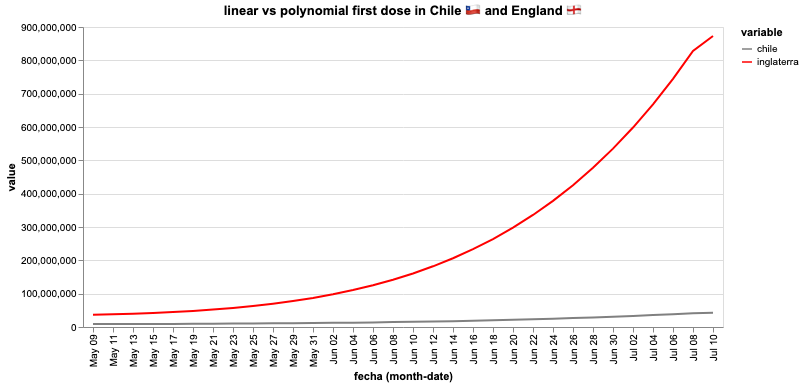

In [102]:
df_ce=df_ce.reset_index()
alt.Chart(df_ce.melt('fecha')).mark_line().encode(
    x='monthdate(fecha):N',
    y=alt.Y('value:Q'),
    color=alt.Color('variable',scale=alt.Scale(domain=['chile','inglaterra'],range=['grey','red']))
).properties(title='linear vs polynomial first dose in Chile 🇨🇱 and England 🏴󠁧󠁢󠁥󠁮󠁧󠁿')


<h4 style="color:orange">Segunda dosis</h4>

In [103]:
inicio = datetime(2021,5,9)
fin    = datetime(2021,6,7)
lista_fechas = [(inicio + timedelta(days=d)).strftime("%Y-%m-%d")
                    for d in range((fin - inicio).days + 1)]
datos = [i for i in range(129,128+len(lista_fechas)+1)]

In [104]:
dictionary_ce={'fecha':lista_fechas,
            'chile':model_poly_ch_ds.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1),
            'inglaterra':model_poly_en_ds.predict(np.array(datos).reshape(len(datos),-1)).reshape(-1)}
df_ce=pd.DataFrame(dictionary_ce)
df_ce['fecha']=pd.to_datetime(df_ce['fecha'])
df_ce=df_ce.groupby(pd.Grouper(key='fecha',freq='1D')).max()

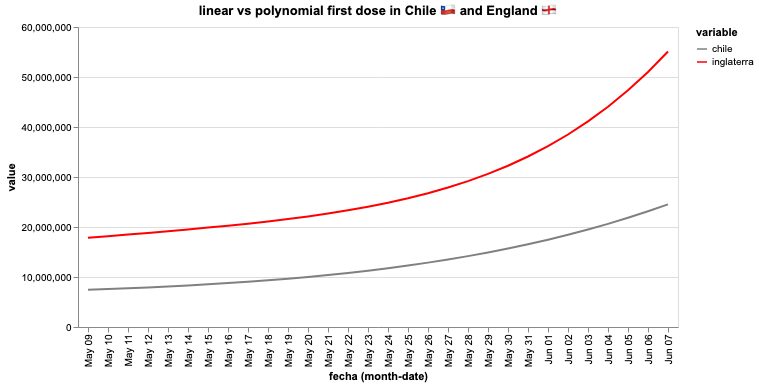

In [105]:
df_ce=df_ce.reset_index()
alt.Chart(df_ce.melt('fecha')).mark_line().encode(
    x='monthdate(fecha):N',
    y=alt.Y('value:Q'),
    color=alt.Color('variable',scale=alt.Scale(domain=['chile','inglaterra'],range=['grey','red']))
).properties(title='linear vs polynomial first dose in Chile 🇨🇱 and England 🏴󠁧󠁢󠁥󠁮󠁧󠁿')
